In [23]:
# %pip install -q tfds-nightly keras tensorflow
# %pip install -q seaborn
# %pip install -q tf2onnx
# %pip install -q onnxmltools
# %pip install --upgrade pip

In [24]:
import pandas as pd
import numpy as np
import matplotlib.dates as date
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import keras
import matplotlib.dates as date
import tensorflow as tf
from datetime import datetime
import seaborn as sns
import onnxmltools

<h1> Read, split, preprocces </h1>

In [25]:
# dataPATH = "lab_window5_RssiPerCrownPerTime.csv"
# dataPATH = "lab_window10_RssiPerCrownPerTime.csv"
# dataPATH = "lab_window20_RssiPerCrownPerTime.csv"
dataPATH = "lab_window30_RssiPerCrownPerTime.csv"

title = 30

df = pd.read_csv(dataPATH, index_col=0)
print(df)

features = df[['0','mean0', 'std0']].copy()

label = df[['distance']].copy()

X_train, X_test, y_train, y_test = train_test_split(
    features, label, test_size=0.2, random_state=1, stratify=label)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

columnames = list(features.columns)+list(label.columns)
# sns.pairplot(df[columnames], diag_kind='kde')

                                 time   0      mean0      std0  distance  \
0    2023-07-14 15:24:58.720000+02:00 -61 -55.133333  5.035963       1.0   
1    2023-07-14 15:24:59.722000+02:00 -61 -55.366667  5.142677       1.0   
2    2023-07-14 15:25:00.723000+02:00 -62 -55.566667  5.282915       1.0   
3    2023-07-14 15:25:02.726000+02:00 -62 -55.666667  5.377689       1.0   
4    2023-07-14 15:25:03.729000+02:00 -68 -56.233333  5.751661       1.0   
..                                ...  ..        ...       ...       ...   
463  2023-07-14 15:34:18.942000+02:00 -80 -79.400000  4.716808      10.0   
464  2023-07-14 15:34:19.946000+02:00 -79 -79.500000  4.673845      10.0   
465  2023-07-14 15:34:20.947000+02:00 -78 -79.666667  4.520706      10.0   
466  2023-07-14 15:34:21.950000+02:00 -85 -79.966667  4.567376      10.0   
467  2023-07-14 15:34:23.955000+02:00 -84 -80.200000  4.589343      10.0   

     posX  posY  
0     1.0   0.0  
1     1.0   0.0  
2     1.0   0.0  
3     1.0   0.0

<h1> Layered Models Build </h1>

In [26]:
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(3,)),  # 3 input features (current RSSI, mean, std)
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # 1 output for distance prediction
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mean_squared_error')

<h1> Training </h1>

In [27]:
# Train the model
history = model.fit(X_train, y_train, validation_split = 0.2, epochs=10000, verbose = 0)

<h1> Evaluating model and Plotting </h1>

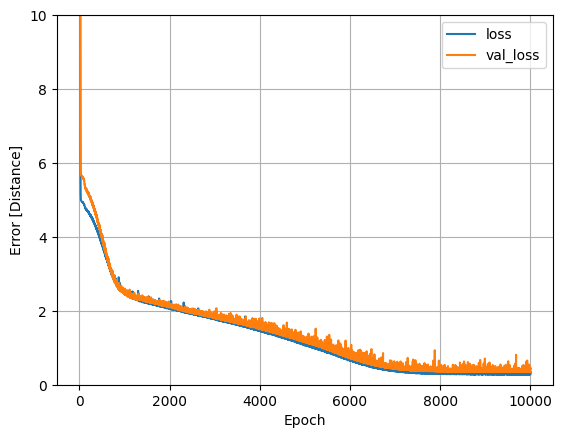

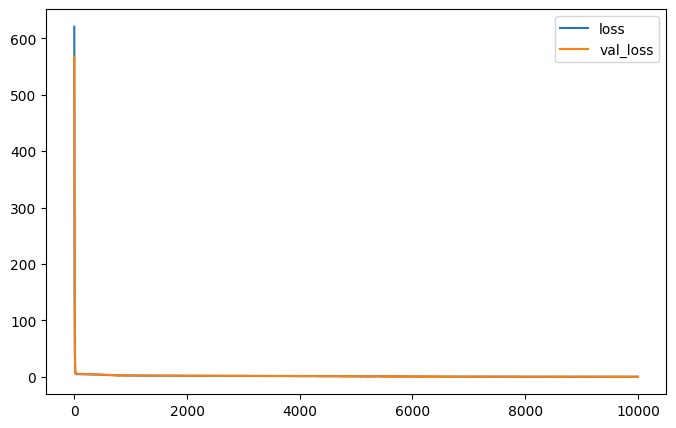

{'rssi2distance_NN': 0.37208083271980286}


In [28]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Distance]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

test_results = {}

test_results['rssi2distance_NN'] = model.evaluate(
    X_test,
    y_test, verbose=0)

print(test_results)

3/3 [==============================] - 0s 3ms/step


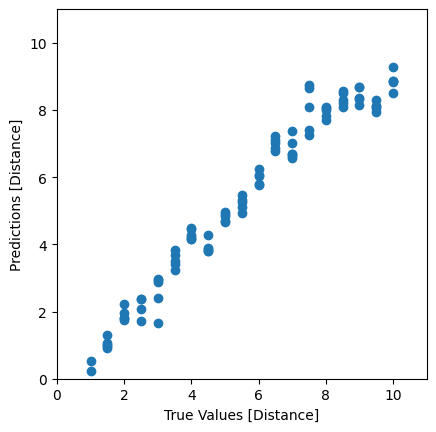

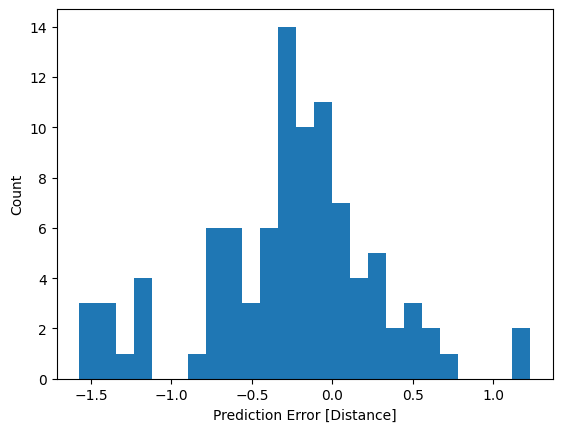

Mean Absolute Error: 0.45576112511310174
Mean Squared Error: 0.3720810265842413
Root Mean Squared Error: 0.6099844478216156

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                256       
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2369 (9.25 KB)
Trainable params: 2369 (9.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
test_predictions = model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [Distance]')
plt.ylabel('Predictions [Distance]')

plt.xlim([0, 11])
plt.ylim([0, 11])
# _ = plt.plot(lims, lims)
plt.show()

y_test = ' '.join(map(str, np.array(y_test).flatten()))
y_test = list(map(float, y_test.split()))

error = test_predictions - y_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Distance]')
_ = plt.ylabel('Count')
plt.show()

mae = mean_absolute_error(y_test, test_predictions)
mse = mean_squared_error(y_test, test_predictions)
rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

# performance metrics on the test data
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print()

model.summary()

<h1> Tensor flow convert to ONNX model for AIDGE convertion </h1>

In [30]:
model.save(('rssi2distance_'+str(title)+'.keras'))

onnx_model = onnxmltools.convert_keras(model) 

onnxmltools.utils.save_model(onnx_model, ('C:/Users/chiel/Desktop/Thesis project/Code/FederatedSpatialModelling/ML models/Rssi2distance/rssi2distance_'+str(title)+'.onnx'))

Could not search for non-variable resources. Concrete function internal representation may have changed.
